In [1]:
import os
from pathlib import Path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from fastai.vision.all import *

Input data files are available in the read-only "../input/" directory

For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
input_dir = Path('/kaggle/input')
for filepath in input_dir.rglob('*'):
    print(filepath)

/kaggle/input/bearimage2
/kaggle/input/bearimage2/bear.jpg
/kaggle/input/bearimage2/bear2.jpg


* You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
* You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Get Search Key
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("AZURE_SEARCH_KEY")
if not key:
    raise ValueError("Azure Search Key not found in secrets")
print((key))

64d5e5efc9194d45a62518d9784129b7


In [4]:
!pip install fastbook > /dev/null

!pip install ipywidgets==7.7.5  > /dev/null

## Fetching Image URLs from Bing

- **Objective**: Retrieve a collection of image URLs for the query `'grizzly bear'` from Bing.
- **Result**: The variable `ims` will store the collection of URLs.
- **fastbook**: Part of the FastAI ecosystem, it provides utilities, functions, and code designed to assist in learning and implementing machine learning concepts.

In [5]:
from fastbook import search_images_bing
search_images_bing
try:
    results = search_images_bing(key, 'grizzly bear')
    ims = results.attrgot('contentUrl')
except Exception as e:
    print(f"Error fetching search results: {e}")
    ims = []
len(ims)

144

# Downloading and displaying an image

## Download one of the images from the URL collection as `images/grizzly.jpg`
- **fastdownload**: A lightweight Python library designed to simplify the downloading and caching of datasets, models, and other resources.
- **download_url**: Downloads the provided URL to the specified destination and shows the progress if desired (default is `True`).

## Open the image using PIL (Python Image Library)
- **python image library** is used for opening, manipulating, and saving image files
- **Image.open**: opens the provided image path
- **to_thumb(128,128)**: displays the image as a thumbnail

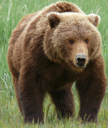

In [6]:
from fastdownload import download_url
dest = 'images/grizzly.jpg'
download_url(ims[1], dest)

from PIL import Image
im = Image.open(dest)
im.to_thumb(128,128)

## Downloading Images for Each Bear Type

**Iterating Over Bear Types**:
  - The **Path** class is used for handling file system paths.
      - *NOTE: the Path object is not creating the directory on the file system; it is just defining a representation of that path*
  - Constructs a `Path` object for each bear type's directory (e.g., `bears/grizzly`).
  - Ensures the directory and any necessary parent directories are created using `mkdir`.
  
**Using Bing Search**:
  - Searches Bing for images of the current bear type using the `search_images_bing` function.
  - Extracts URLs of the images from the search results.
      - **results** -information about the found images, including their URLs.
      - **urls=results.attrgot('contentUrl')** - creates a collection of urls from the 'contentUrl' property of each result

**Downloading Images**:
  - Downloads the images from the collected URLs into the appropriate directory (`dest`) using `download_images`.

In [7]:
from pathlib import Path
from fastai.vision.all import download_images

bear_types = 'grizzly','black','teddy'
# a Path object representing the directory bears
path = Path('bears')    

# Iterates over each type of bear in the tuple bear_types (i.e., 'grizzly', 'black', 'teddy').
for o in bear_types:
    dest = (path/o) 
    dest.mkdir(parents=True, exist_ok=True)  
    results = search_images_bing(key, f'{o} bear') 
    download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, get_image_files, Resize, ResizeMethod

## Validating and Cleaning Up Image Files

This code is responsible for validating a collection of image files and removing any invalid or unreadable images. Here's a step-by-step explanation:

### Step 1: Retrieve All Image Files
- **Function**: `get_image_files(path)`
  - Recursively retrieves all image files from the specified directory (`path`).
  - Returns a list of file paths.
- **Result**: Stores the list of image file paths in the variable `fns`.

### Step 2: Verify Image Files

- **Function**: `verify_images(fns)`
  - Verifies whether each file in `fns` is a valid and readable image.
  - Returns a collection of file paths (`failed`) for images that cannot be opened or are corrupted.

### Step 3: Remove Invalid Images

**map** applies a function to every element in the collection,

- **Function**: failed.map(Path.unlink)`:
  - Applies the `Path.unlink` method to each file path in the `failed` collection.

- **Function**: Path.unlink()`:
  - Deletes the file from the filesystem.
  - Ensures that only valid image files remain in the dataset.

In [9]:
from fastai.vision.utils import get_image_files, verify_images

fns = get_image_files(path)
print(f"Number of images found: {len(fns)} in path {path}")

failed = verify_images(fns) 
print(f"Number of images that can't be opened: {len(failed)}")

failed.map(Path.unlink);

Number of images found: 403 in path bears
Number of images that can't be opened: 30


## DataBlock: Defining the Dataset Processing Pipeline

This `DataBlock` defines the steps for processing a dataset, and the specific `DataBlock` object here is named `bears`.

### Key Components of the `bears` DataBlock

#### 1. **`blocks`**
   - Specifies the types of input (`x`) and target (`y`) data.
   - In this case:
     - `ImageBlock`: The input data consists of images.
     - `CategoryBlock`: The target (label) is a category (e.g., the type of bear).

#### 2. **`get_items`**
   - Defines how to retrieve the input data.
   - Uses `get_image_files`, a function that recursively retrieves all image files from a given path.

#### 3. **`splitter`**
   - Determines how to split the dataset into training and validation sets.
   - Uses `RandomSplitter` with the following parameters:
     - `valid_pct=0.2`: 20% of the data is assigned to the validation set.
     - `seed=42`: Ensures the random split is reproducible (the same split will occur with each run).

#### 4. **`get_y`**
   - Defines how to extract the label (category) for each input.
   - Uses `parent_label`, which assumes the label is the name of the parent directory containing the image file.

#### 5. **`item_tfms`**
   - Specifies transformations to apply to each individual item in the dataset.
   - Applies `Resize(128)`, which resizes all images to 128x128 pixels to standardize input sizes for the model.

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

## Understanding the `DataLoaders` Object

- A **`DataLoaders`** object is a FastAI abstraction for managing and iterating over datasets during the training and validation process.
- **Purpose**:
  - Simplifies the process of loading data into batches.
  - Wraps together one or more `DataLoader` objects:
    - `dls.train`: For training data.
    - `dls.valid`: For validation data.

---

### Creating a `DataLoaders` Object

- **`bears`**: The `DataBlock` defined earlier, specifying how the dataset is structured and processed.
- **`dls`**: The resulting `DataLoaders` object created by calling `.dataloaders(path)` on the `DataBlock`.
  - `path`: The directory where the dataset is stored.
 
---

### Visualizing Validation Data

- **`dls.valid.show_batch()`**:
  - Displays a batch of validation data (images and labels) for inspection.

#### Parameters:
- **`max_n=4`**:
  - Displays up to 4 samples from the validation set.
- **`nrows=1`**:
  - Arranges the images in a single row for easy viewing.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


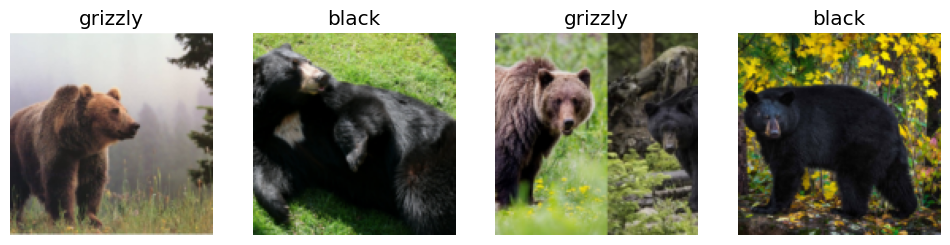

In [11]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Explanation of `ResizeMethod.Squish`

- **`ResizeMethod.Squish`**:
  - This method resizes an image by squishing it into the specified dimensions without preserving the original aspect ratio.
  - The image's width and height are adjusted independently to fit the target size, which can result in distortion if the aspect ratio of the original image differs from the target dimensions.

#### Use Case:
- Useful when maintaining the aspect ratio is not a priority, and you need a quick and simple way to standardize image dimensions.

#### Example:
If an image of size `200x400` is resized to `128x128` using `ResizeMethod.Squish`, the output image will be exactly `128x128` but appear stretched or compressed.

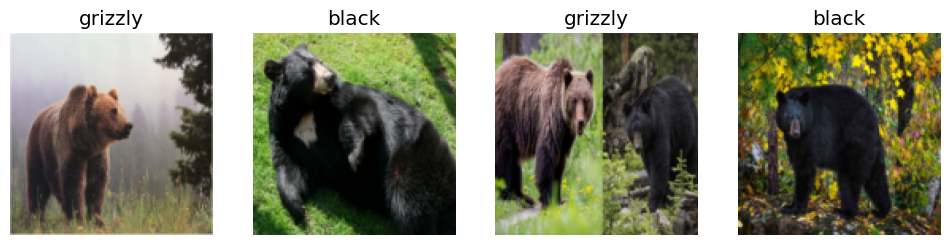

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Understanding `ResizeMethod.pad`

- **`ResizeMethod.pad`**:
  - A resizing method in FastAI used to resize images to a specific size while maintaining the aspect ratio.
  - Adds padding (empty space) to the shorter side of the image to ensure the final dimensions match the desired size.

#### Key Points:
- **Aspect Ratio**: Preserves the original aspect ratio of the image.
- **Padding**:
  - The shorter side of the image is padded with a specified color (default is black) to match the desired dimensions.
  - This avoids distortion or cropping of the image.
- **Use Case**:
  - Ideal when you want to maintain the entire content of an image without altering its proportions.

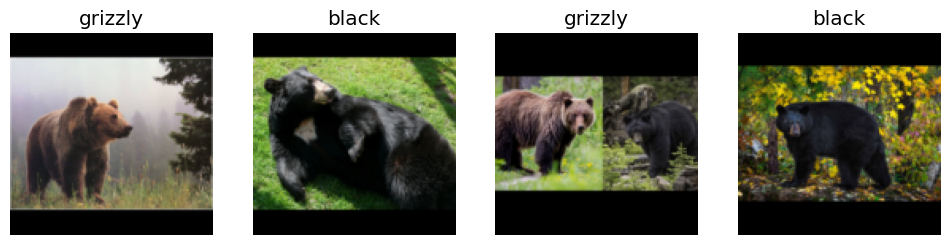

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Understanding `RandomResizedCrop`

- **Purpose**:
  - `RandomResizedCrop` is a data augmentation technique commonly used in image processing pipelines.
  - It randomly crops a region from an image and resizes it to a specified size. This helps introduce variability in the dataset and improves model generalization.

---

### Parameters

- **`size`**:
  - The target size (e.g., `128` or `(128, 128)`) to which the cropped region will be resized.
- **`min_scale`**:
  - The minimum scale for the cropped region as a fraction of the original image size (default: `0.08`).
  - Larger values result in smaller crop regions.
- **`ratio`**:
  - Aspect ratio range for the cropped region (default: `(3/4, 4/3)`).
  - Ensures the crop doesn’t distort the image too much.
- **`resamples`**:
  - Resampling filters used during resizing (e.g., `Image.BILINEAR`).

---

### Key Benefits

- Introduces randomness to the dataset, preventing the model from overfitting to specific image details.
- Ensures all images have the same size after augmentation, which is required for neural network input.
- Provides robustness to variations in object position, size, and aspect ratio.

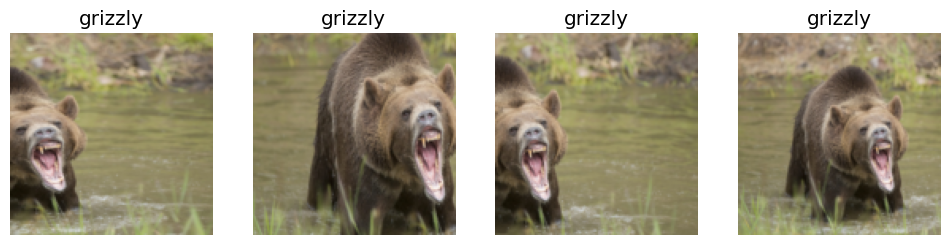

In [14]:
from fastai.vision.all import RandomResizedCrop

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation
***Data augmentation*** - creating random variations of our input data
- Examples of common data augmentation techniques for images (rotation, flipping, perspective warping, brightness and contrast changes)
- To tell fastai we want to use these transforms on a batch, we use the **batch_tfms** parameter
- We're also using double the amount of augmentation compared to the default

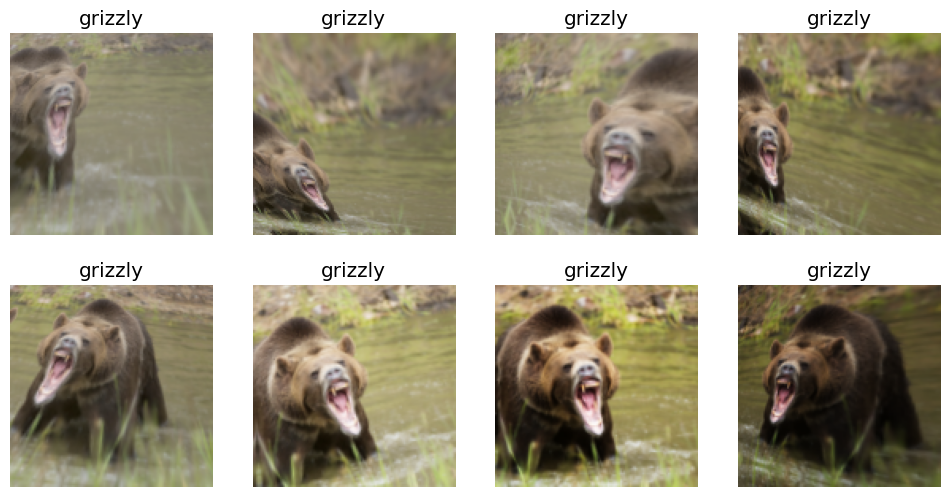

In [15]:
from fastai.vision.augment import aug_transforms
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
bears = bears.new(
    #RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

## Train a deep learning model for image classifictaion using the FastAI library

This code is responsible for validating a collection of image files and removing any invalid or unreadable images. Here's a step-by-step explanation:


### Step 1: Create a Vision Learner
**What it does:**
- `vision_learner`
  - A helper function in FastAI that simplifies creating a deep learning model for image-related
  - Automatically integrates the data (`dls`), architecture (`resnet18`), and evaluation metric (`error_rate`).
- **Parameters**:
    - `dls`: The `DataLoaders` object containing the training and validation datasets.
    - `resnet18`: A pre-trained convolutional neural network (CNN) model (ResNet-18).
        - ResNet-18 is a lightweight architecture commonly used for image classification tasks.
        - Pre-trained weights (on ImageNet) are used, which speeds up training and improves accuracy.
    - `metrics=error_rate`:
        - Specifies the evaluation metric.
        - `error_rate`: The fraction of incorrect predictions (1 - accuracy).
- **Output**:
    - Returns a `Learner` object (`learn`), which encapsulates the model, data, and training configurations.
 
> A Learner object in FastAI serves as the central interface for training, validating, and interpreting machine learning models. It simplifies the entire training process by seamlessly connecting the dataset, model, and evaluation metrics into a cohesive framework.

---

### Step 2: Fine-Tune the Model
**What it does:**:
- `fine_tune`
  - Adapts the pre-trained ResNet-18 model to the new dataset using transfer learning
  - Fine-tuning adjusts the model's parameters to perform well on the current task while leveraging the pre-trained weights.
- **Parameter**:
    - `4`: The number of epochs for fine-tuning.
        - One epoch means the model processes the entire dataset once during training.
        - In this case, the model fine-tunes for 4 epochs.
- **Steps in Fine-Tuning**:
    - **Stage 1**: Trains only the final (head) layer of the model (newly added for the dataset) while freezing the pre-trained layers.
    - **Stage 2**: Unfreezes the entire model and fine-tunes all layers with a smaller learning rate.

 ---
  
### Purpose and Benefits

- **Transfer Learning**: 
  - The pre-trained ResNet-18 model already knows how to extract features from images (e.g., edges, textures, shapes).
  - Fine-tuning adjusts these features to the specific dataset, saving time and improving performance.

- **Error Rate**:
  - Tracks the fraction of incorrect predictions during training, helping monitor model performance.

In [ ]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.701869,0.412418,0.175676,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.574639,0.306412,0.121622,00:55


## Sample Results and Explanation

The results displayed in this table are typical outputs from training a machine learning model using FastAI, showing metrics for each epoch during training and fine-tuning. Here’s a detailed explanation of each column and what these results indicate:

---

### Columns in the Output
- `epoch`:
    - Represents the current epoch (one full pass through the training dataset).
    - Starts at 0 and increments with each additional epoch.
- `train_loss`:
    - The loss calculated on the training dataset for that epoch
    - A lower value indicates the modle is performing better on the training data
- `valid_loss`:
    - The loss calculated on the validation dataset for that epoch
    - A decreasing validation loss indicates the model is generalizing well to unseen data
- `error_rate`:
    - A metric representing the fraction of incorrect predictions (1 - accuracy).
    - A lower value is better and indicates that the model is making fewer incorrect predictions.
- `time`:
    - The time taken to complete the epoch (training and validation combined).
 
---

### Results Interpretation
**First Table (Before Fine-Tuning)**
- The model trains for one epoch and achieves the following:
    - `train_loss`:1.074360 — High at the start, as expected for an untrained model
    - `valid_loss`:0.098378 — Significantly lower than train_loss, suggesting that the model quickly learns from the data.
    - `error_rate`:0.033333 — Indicates that the model has an error rate of 3.3% on the validation dataset after one epoch.
      
This stage likely corresponds to training only the "head" of the pre-trained model (the final classification layer), while the other layers remain frozen.  

**Second Table**
- The model undergoes 4 epochs of fine-tuning, where all layers are unfrozen, and the entire network is trained
    - **Epoch 0**:
        - `train_loss` drops significantly to 0.142627, showing improvement as more layers are trained.
        - `valid_loss` is 0.081108, indicating good performance on the validation set.
        - `error_rate` is 0.026667 (2.7%), showing better accuracy than the first stage.
    - **Epoch 1-3**:
        - Both `train_loss` and `valid_loss` continue to decrease
            - `train_loss` reaches 0.050202 at the end, suggesting that the model fits the training data well
            - `valid_loss` stabilizes at 0.047072, showing good generalization to the validation set.
        - The `error_rate` drops further to 0.013333 (1.3%), reflecting an improved ability to classify validation data correctly.

---

### Key Observations
- **Decreasing Loss and Error Rate**
    - Both `train_loss` and `valid_loss` decrease over time, which is expected during successful training and fine-tuning.
    - The `error_rate` also decreases, confirming improved model accuracy.
- **Consistency in Validation Performance**
    - The gap between `train_loss` and `valid_loss` remains small, which suggests the model is not overfitting and generalizes well to unseen data.
- **Effectiveness of Fine-Tuning**
    - Fine-tuning (unfreezing and training all layers) significantly improves both the `valid_loss` and `error_rate` compared to the initial stage.

# What is `ClassificationInterpretation`?

The `ClassificationInterpretation` class in FastAI provides tools to evaluate the performance of a trained classification model. It helps analyze where the model performs well and where it struggles, offering insights into its predictions.

---

## Key Features of `ClassificationInterpretation`

### 1. Confusion Matrix
- Visualizes the relationship between predicted and actual classes.
- Helps identify patterns in misclassifications.

### 2. Top Losses
- Identifies and displays the samples where the model had the highest prediction loss.
- Useful for diagnosing why the model struggled with specific examples.

### 3. Most Confused Classes
- Lists the pairs of classes the model most frequently confuses.
- Helps understand where the model’s predictions overlap.

In [ ]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Understanding the Confusion Matrix and Loss in FastAI

### Confusion Matrix
- **Rows**: Represent the actual classes in the dataset (e.g., black, grizzly, and teddy bears).
- **Columns**: Represent the predicted classes (e.g., black, grizzly, and teddy bears).
- **Diagonal**: Shows the correctly classified images.
- **Off-diagonal cells**: Show misclassified images.
- The goal is to have **dark blue on the diagonal** (correct predictions) and **white elsewhere** (few mistakes).
- The confusion matrix is calculated using the validation set, and FastAI makes it easy to visualize model results.

### Analyzing Errors
- Understanding errors helps identify whether they're caused by:
  - **Dataset problems** (e.g., mislabeled data or non-bear images).
  - **Model limitations** (e.g., struggles with unusual lighting or angles).

### Loss
- **Definition**: A number representing how well the model’s prediction matches the actual label.
  - Higher loss: Model is wrong (especially if it’s confident about the wrong answer).
  - Lower loss: Model is correct or unsure about its prediction.
- **`plot_top_losses`**: Displays the images with the highest loss, helping identify challenging cases.
- Each image is labeled with:
  1. **Prediction**: The model’s predicted class.
  2. **Actual**: The correct label.
  3. **Loss**: The calculated loss for that prediction.
  4. **Probability**: The model’s confidence level (from 0 to 1) in its prediction.

In [ ]:
interp.plot_top_losses(5, nrows=1)


* This output shows the image with the highest loss. We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label.
* The intuitive approach to doing data cleaning is to do it before you train a model. But a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.
* fastai includes a handy GUI for data cleaning called **ImageClassifierCleaner** that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
from ipywidgets import VBox 
# IPython widgets are GUI components that bring together JavaScript and Python functionality in a web browser

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# to delete (unlink) all images selected for deletion, we would run:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
# To move images for which we've selected a different category, we would run:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### **Using the Model for Inference**

***When we use a model for getting predictions, instead of training, we call it inference***

Once you've trained and finalized a model, the next step is to save it so that it can be used in production. This involves copying the saved model to a production server or environment for inference. Here's how you can efficiently save and prepare your model:

---

#### **Why Save the Model?**
- Saving ensures you retain both:
  1. **The architecture**: The structure of the neural network.
  2. **The trained parameters**: The learned weights and biases from training.
  
  Combining these ensures that when you load the model, the architecture and parameters are correctly aligned, avoiding mismatches or errors.

---

#### **How to Save the Model?**
- Use the `export` method in FastAI:
  ```python
  learn.export()

In [ ]:
learn.export()

path = Path()
path.ls(file_exts='.pkl')

When we use a model for getting predictions, instead of training, we call it inference. To create our inference learner from the exported file, we use load_learner (in this case, this isn't really necessary, since we already have a working Learner in our notebook; we're just doing it here so you can see the whole process end-to-end)

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to predict:

In [ ]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')

### **Understanding the Prediction Output**

When analyzing the output of `learn_inf.predict`, it provides detailed information about the model's prediction. Here's a breakdown:

---

#### **1. Predicted Class**
- The first element in the output, `'grizzly'`, represents the **predicted class** for the input image.
- This is a string label corresponding to the category that the model predicts the input image belongs to.
- In this case, the model predicts that the image belongs to the `'grizzly'` class.

---

#### **2. Tensor Index**
- The second element, `tensor(1)`, is a **numerical representation of the predicted class index**.
- FastAI assigns an integer index to each class in your dataset. For example:
  - `0`: Black bear
  - `1`: Grizzly bear
  - `2`: Teddy bear
- In this case, the tensor value `1` corresponds to the `'grizzly'` class.

---

#### **3. Prediction Probabilities**
- The third element, `tensor([5.4334e-06, 9.9999e-01, 3.2537e-06])`, is a **tensor of probabilities** for each class.
- This shows the model's confidence in its prediction for each class.
- Each value represents the likelihood of the input image belonging to a specific class, in the same order as the class indices:
  - `0`: Black bear → `5.4334e-06` (~0.000005%)
  - `1`: Grizzly bear → `9.9999e-01` (~99.9999%)
  - `2`: Teddy bear → `3.2537e-06` (~0.000003%)
- In this case, the model is almost certain (with a 99.9999% probability) that the input image is a `'grizzly'`.

---

#### **Summary**
The output indicates:
1. The model predicts the input image is of class `'grizzly'`.
2. The numerical index of this class is `1`.
3. The model is highly confident in this prediction, assigning nearly 100% probability to the `'grizzly'` class.

This comprehensive output provides both the predicted label and detailed probabilities, which can help evaluate the confidence and reliability of the model’s prediction.

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [ ]:
learn_inf.dls.vocab

In [ ]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('/kaggle/input/bearimage2/bear2.jpg')

In [ ]:
learn_inf.dls.vocab

# Creating a Notbook Web Application from the Model

`Voilà` is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all.

In [ ]:
from ipywidgets import widgets, VBox
from IPython.display import display
from fastai.vision.all import PILImage
import os

# File upload widget
btn_upload = widgets.FileUpload(accept='image/*', multiple=False)
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()

# Function to handle classification
def on_click_classify(change):
    out_pl.clear_output()  # Clear previous output
    if btn_upload.value:
        print("Raw btn_upload.value:", btn_upload.value)  # Debugging log
        
        # Access the first file in the tuple
        uploaded_file = btn_upload.value[0]  # Access tuple directly
        print(f"Uploaded file details: {uploaded_file}")

        # Extract file content and metadata
        try:
            file_content = uploaded_file['content']
            filename = uploaded_file['name']
            print(f"File name: {filename}")
            
            # Save the file to a local path
            temp_path = f'/kaggle/working/{filename}'
            with open(temp_path, 'wb') as f:
                f.write(file_content.tobytes())  # Convert memoryview to bytes
            
            print(f"File saved to: {temp_path}")
            
            # Try to load and display the image
            try:
                img = PILImage.create(temp_path)
                print("Image successfully loaded.")
                with out_pl:
                    display(img.to_thumb(128, 128))

                # Perform prediction
                pred, pred_idx, probs = learn_inf.predict(img)
                lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
            except Exception as e:
                print("Error loading image with PILImage.create:", e)
                lbl_pred.value = "Failed to process the uploaded image. Ensure it's a valid image file."
        except Exception as e:
            print("Error handling file content:", e)
            lbl_pred.value = "Error processing the uploaded file. Please try again."
    else:
        lbl_pred.value = 'Please upload an image first!'

# Attach event to button
btn_run.on_click(on_click_classify)

# Display widgets in a vertical layout
display(VBox([
    widgets.Label('Select your bear!'),
    btn_upload,
    btn_run,
    out_pl,
    lbl_pred
]))